# Multiple Gravity Assist (MGA)

In this tutorial, we use the {class}`pykep.trajopt.mga` to design an interplanetary trajectory. The MGA encoding of an interplanetary trajectory
models multiple (pre-defined) planetary encounters, and enables for propulsion manovures in the form of instantaneous $\Delta V$ immediately after each fly-by.
The encoding is useful as a preliminar mission design tool automating the search for good planetary geometries giving the possibility to design trajectories through a process
mimicking natural evolution.

This encoding has also been used in the past to define instances of real-world optimization problems to be used in benchmarking optimization tools suitable for interplanetary mission design.

:::{note}
{class}`pykep.trajopt.mga` also implements different (unpublished) encodings for the time of flights, namely called $\alpha$-encoding and $\eta$-encoding which, albeit less studied and creating a more complex fitness landscape, are interesting in multiple ways: a) they show how the encoding influences evolvability in a drastic way b) they allow to box-bound the total trajectory time of flight c) they remove problem knowledge exploitation.

We start, as often, with some fundamental imports:

In [1]:
import pykep as pk
import pygmo as pg
import matplotlib.pyplot as plt

We will study the possibility of establishing an Earth return trajectory visiting venus in two different epochs and mars in between:

In [2]:
earth = pk.planet(pk.udpla.jpl_lp("earth"))
venus = pk.planet(pk.udpla.jpl_lp("venus"))
mars = pk.planet(pk.udpla.jpl_lp("mars"))
udp = pk.trajopt.mga(
    seq=[
        earth,
        venus,
        mars,
        venus,
        earth
    ],
    tof_encoding = "direct",
    t0=[0, 1000],
    tof=[[30, 200], [30, 300], [30, 350], [30, 300]],
    vinf=5.,
)

To solve this problem we will use an adaptive version of differential evolution, even if other meta-heuristic would also be possible. We run the algorithm in mult-start, to get a sense of the fitness landscape and complexity.

In [3]:
prob = pg.problem(udp)
# CMA-ES is also possible
#uda = pg.cmaes(1500, force_bounds=True, sigma0=0.5, ftol=1e-4)
# But we prefer a self adaptive version of differential evolution here
uda = pg.sade(2500, ftol=1e-4, xtol=1e-4)
algo = pg.algorithm(uda)
res = list()
for i in range(10):
    pop = pg.population(prob, 20)
    pop = algo.evolve(pop)
    res.append([pop.champion_f, pop.champion_x])
    print(i, pop.champion_f[0], flush=True)
    
best_x = sorted(res, key =  lambda x: x[0][0])[0][1]

0 3784.5101977008676
1 4705.043952239474
2 3782.557283281636
3 3784.532718276872
4 3788.9239423070926
5 4705.044657292304
6 4705.044107630107
7 3788.5143651174744
8 3787.803009405878
9 3784.8076519016845


## Plotting the trajectory
There are several ways one can plot the solution, depending on what we want to 'see'. Lets start with one "at-a-glance" plot:

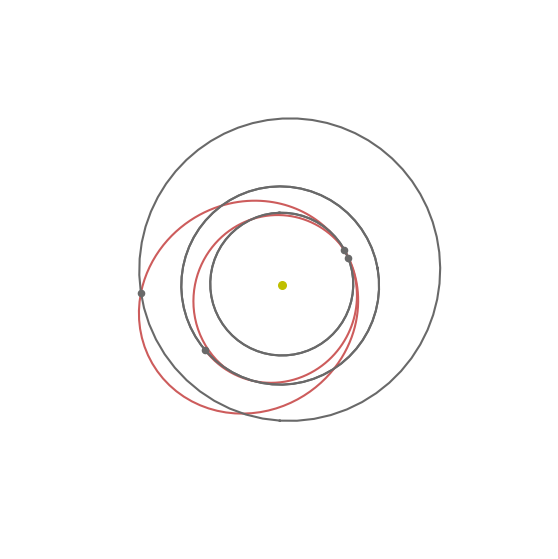

In [4]:
ax = udp.plot(best_x, figsize=(7, 7))
ax.view_init(90, 0)
ax.axis("off");

If we need to disentangle the sequence of the varioous legs we may also subdivide them in subplots:

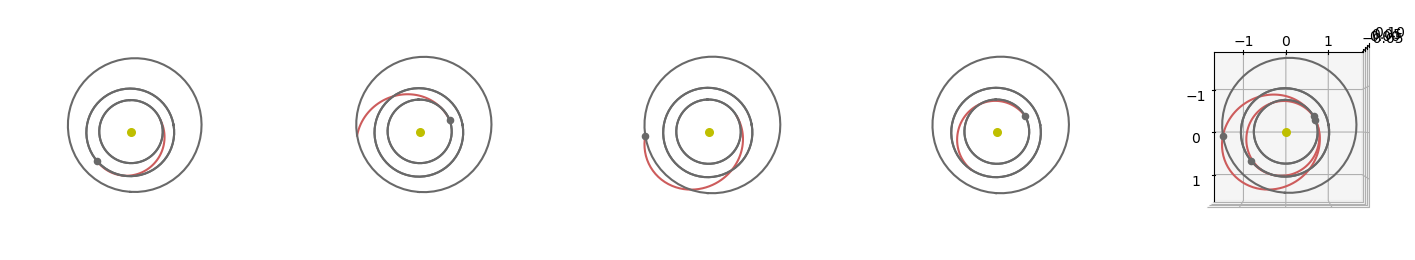

In [5]:
# The figure
fig = plt.figure(figsize=(18,18))

# The single leg plots
for i in range(1,5):
    ax = fig.add_subplot(1, 5, i, projection="3d")
    ax.view_init(90, 0)
    ax = udp.plot(best_x, ax=ax, leg_ids=[i-1])
    ax.axis("off");
    
# All the legs
ax = fig.add_subplot(1, 5, 5, projection="3d")
ax.view_init(90, 0)
ax = udp.plot(best_x, ax=ax)

... or show the various xy, xy, xz views as well as a full 3D one:

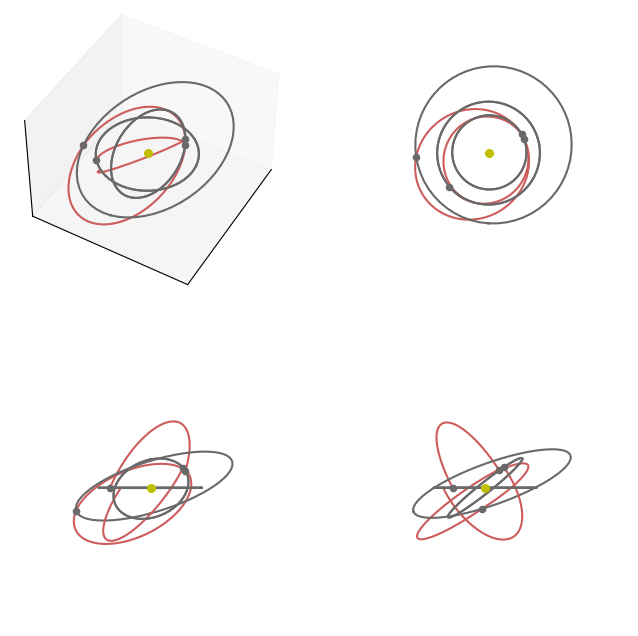

In [6]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(45, 30)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.get_zaxis().set_ticks([])

ax = fig.add_subplot(2, 2, 2, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(90, 0)
ax.axis("off")

ax = fig.add_subplot(2, 2, 3, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(0, 0)
ax.axis("off")

ax = fig.add_subplot(2, 2, 4, projection="3d")
ax = udp.plot(best_x, ax=ax)
ax.view_init(0, 90)
ax.axis("off");

## Analyzing the trajectory
For a quick analysis of the trajectory we may use the pretty method.

In [7]:
ax = udp.pretty(best_x)


Multiple Gravity Assist (MGA) problem: 
	Planet sequence:  ['earth(jpl_lp)', 'venus(jpl_lp)', 'mars(jpl_lp)', 'venus(jpl_lp)', 'earth(jpl_lp)']
	Encoding for tofs:  direct
	Orbit Insertion:  False
Departure:  earth(jpl_lp)
	Epoch:  944.5900947312232  [mjd2000]
	Spacecraft velocity:  [20377.954757865893, 17267.375991881287, 2927.6581254372268] [m/s]
	Hyperbolic velocity:  3942.0019711155164 [m/s]
	Initial DV:  0 [m/s]
Fly-by:  venus(jpl_lp)
	Epoch:  1080.451629586074  [mjd2000]
	DV:  0.00046151242713676766 [m/s]
Fly-by:  mars(jpl_lp)
	Epoch:  1235.102937062856  [mjd2000]
	DV:  3.8450598367489874e-06 [m/s]
Fly-by:  venus(jpl_lp)
	Epoch:  1534.6847170103094  [mjd2000]
	DV:  0.0002847293799277395 [m/s]
Arrival:  earth(jpl_lp)
	Epoch:  1691.3679239438504  [mjd2000]
	Spacecraft velocity:  [15478.924184098158, 21751.80200637948, 2470.7569522966114] [m/s]
	Arrival DV:  3782.556533194769 [m/s]
Time of flights:  [135.86153485 154.65130748 299.58177995 156.68320693] [days]

Total DV:  3782.557283